# **Custom Knowledge ChatGPT with LangChain - Chat with PDFs**

**By Liam Ottley:**  [YouTube](https://youtube.com/@LiamOttley)





0.   Installs, Imports and API Keys
1.   Loading PDFs and chunking with LangChain
2.   Embedding text and storing embeddings
3.   Creating retrieval function
4.   Creating chatbot with chat memory (OPTIONAL)








# 0. Installs, Imports and API Keys

In [ ]:
# RUN THIS CELL FIRST!
# !pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [3]:
# os.environ["OPENAI_API_KEY"]

# 1. Loading PDFs and chunking with LangChain

In [10]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("./attention_is_all_you_need.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to\nbe superior in quality while being more parallelizable

In [41]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text

import PyPDF2

def convert_pdf_to_txt(file_path):
    pdf_file_obj = open(file_path, 'rb')
    pdf_reader = PyPDF2.PdfReader(pdf_file_obj)
    
    text = ""
    # print(pdf_reader.pages[0].extract_text())
    for page in pdf_reader.pages:
        
        text += page.extract_text()
    
    pdf_file_obj.close()
    
    return text

# Path to the PDF file
pdf_path = './attention_is_all_you_need.pdf'

# Convert PDF to text
text = convert_pdf_to_txt(pdf_path)
# print(text)
# Write the text to a .txt file
with open(f'{pdf_path[:-4]}.txt', 'w', encoding='utf-8') as f:
    f.write(text)



with open('attention_is_all_you_need.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)


In [42]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.Document

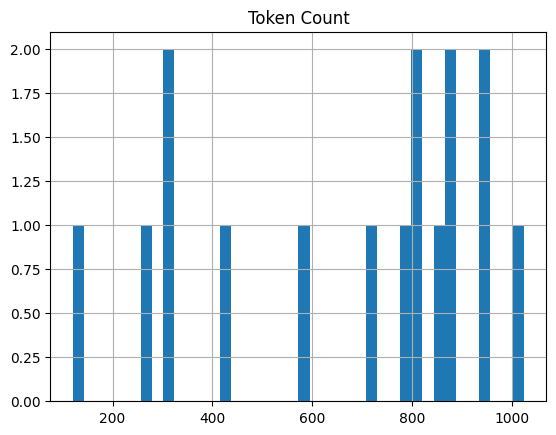

In [43]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [44]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [45]:
# Check similarity search is working
query = "Who created transformers?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='Attention Is All You Need\nAshish Vaswani\x03\nGoogle Brain\navaswani@google.comNoam Shazeer\x03\nGoogle Brain\nnoam@google.comNiki Parmar\x03\nGoogle Research\nnikip@google.comJakob Uszkoreit\x03\nGoogle Research\nusz@google.com\nLlion Jones\x03\nGoogle Research\nllion@google.comAidan N. Gomez\x03y\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser\x03\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin\x03z\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to\nbe superior in quality while being more paral

In [46]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "Who created transformers?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, and Łukasz Kaiser created transformers.'

# 5. Create chatbot with chat memory (OPTIONAL)

In [47]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [49]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


C:\Users\matan.s\AppData\Local\Temp\ipykernel_20980\3589111581.py:20: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> what is Attention is all you need?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Attention is All You Need is a paper by Ashish Vaswani,…